In [1]:
import sys
# Append the previous directory to the path
sys.path.append('../')

In [2]:
import os

import shap
import lime
import seaborn as sns
from nice import NICE
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from exp_utils import counterplot_explainer, shap_explainer, lime_explainer, generate_explanations


In [3]:
# Create dataset
simple_models_dataset = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=5, 
    n_redundant=0,
    n_repeated=0, 
    n_classes=2,
    random_state=42)

X_simple_models_dataset, y_simple_models_dataset = simple_models_dataset

#### Logistic Regression
Here a logistic regression is used with an artificially generated dataset.
The dataset has 1000 samples with 5 informative features and 2 classes.

In [4]:
# Import scikit-learn logistic regression package
from sklearn.linear_model import LogisticRegression
from counterplots import CreatePlot

In [5]:
# Create logistic regression model with default parameters and random state 42
lr_model = LogisticRegression(random_state=42, penalty='none', fit_intercept=False)

In [6]:
# Train logistic regression model
lr_model.fit(X_simple_models_dataset, y_simple_models_dataset)

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.


LogisticRegression(fit_intercept=False, penalty='none', random_state=42)

In [7]:
# Print the accuracy of the logistic regression model
print("Accuracy of logistic regression model: ", lr_model.score(X_simple_models_dataset, y_simple_models_dataset))

Accuracy of logistic regression model:  0.789


In [8]:
# Print LR weights
print("LR weights: ", lr_model.coef_)

LR weights:  [[-0.58999013  0.66743407  0.7849269  -0.33591243 -0.59442337]]


In [9]:
# Print LR weights in LaTeX table format, rouded to 2 decimals
print("LR weights in LaTeX table format: ")
print(pd.DataFrame(lr_model.coef_).round(2).to_latex(index=False, header=False))

LR weights in LaTeX table format: 
\begin{tabular}{rrrrr}
\toprule
-0.59 & 0.67 & 0.78 & -0.34 & -0.59 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [10]:
# Select points classified as 0
lr_0_class_points = X_simple_models_dataset[lr_model.predict(X_simple_models_dataset) == 0]

In [11]:
# Create NICE counterfactuals for 0 classified points
lr_nice_cf = NICE(
    predict_fn=lr_model.predict_proba, 
    X_train=X_simple_models_dataset, 
    y_train=y_simple_models_dataset, 
    cat_feat=[])
lr_cfs = [lr_nice_cf.explain(np.array([x])) for x in lr_0_class_points]

# Create CounterPlot Explanation Generator
lr_ctp_exp = counterplot_explainer(
    lambda x: lr_nice_cf.explain(np.array([x]))[0], 
    ['x1', 'x2', 'x3', 'x4', 'x5'], 
    {0: '0', 1: '1'},
    lr_model.predict_proba)

# Create CounterPlot explanations
lr_cpt_results, lr_cpt_results_idx, lr_cpt_gen_times = generate_explanations(
    lr_0_class_points, lr_ctp_exp.explain)

In [12]:
# Create SHAP explainer object
lr_shap = shap.KernelExplainer(lr_model.predict_proba, X_simple_models_dataset)

# Create SHAP explanation generator
lr_shap_exp = shap_explainer(lr_shap.shap_values)

# Create SHAP explanations
lr_shap_results, lr_shap_results_idx, lr_shap_gen_times = generate_explanations(
    lr_0_class_points, lr_shap_exp.explain)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [13]:
# Create LIME explainer object
lr_lime = lime.lime_tabular.LimeTabularExplainer(
    X_simple_models_dataset, 
    feature_names=["x1", "x2", "x3", "x4", "x5"], 
    class_names={0: "0", 1: "1"})

# Create LIME explanation generator
lr_lime_exp = lime_explainer(lr_lime, lr_model.predict_proba)

# Create LIME explanations
lr_lime_results, lr_lime_results_idx, lr_lime_gen_times = generate_explanations(
    lr_0_class_points, lr_lime_exp.explain)

In [14]:
import matplotlib.pyplot as plt

# Create path './plots/simple_models' if not exists
os.makedirs('./plots/simple_models', exist_ok=True)

def create_hist_fi(feat_idx, fi_data, features_labels, limits_x, limits_y, save_path):
    try:
        # Plot size must be 4x5
        plt.figure(figsize=(4, 5))
        # Histogram with a red line showing the mean
        sns.histplot(pd.DataFrame(fi_data)[feat_idx].round(8))
        # plt.xlabel(f'{features_labels[feat_idx]} feature importance')
        plt.xlabel('')
        plt.axvline(pd.DataFrame(fi_data)[feat_idx].mean(), color='r', linestyle='dashed', linewidth=1)
        plt.xlim(limits_x)
        plt.ylim(limits_y)
        plt.savefig(save_path, bbox_inches='tight')
        # Clear the plot
        plt.clf()
    except:
        plt.clf()
        plt.savefig(save_path, bbox_inches='tight')
        plt.clf()
        pass
    
for method_name, fi_data in zip(['cf', 'shap', 'lime'], [lr_cpt_results_idx, lr_shap_results_idx, lr_lime_results_idx]):
    for feat_idx in range(5):
        create_hist_fi(feat_idx, fi_data, ["1st", "2nd", "3rd", "4th", "5th"], [-0.5, 0.6], [0, 200], f'./plots/simple_models/{method_name}_{feat_idx}.pdf')

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

In [15]:
# Get times which importance values were different from 0

iw_lr_cpt = (pd.DataFrame(lr_cpt_results_idx).abs() >= 1e-10 ).mean().sort_index()
iw_shap_cpt = (pd.DataFrame(lr_shap_results_idx).abs() >= 1e-10 ).mean().sort_index()
iw_lime_cpt = (pd.DataFrame(lr_lime_results_idx).abs() >= 1e-10 ).mean().sort_index()

pd.DataFrame([iw_lr_cpt, iw_shap_cpt, iw_lime_cpt], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1,2,3,4
CounterPlot,0.582888,0.532977,0.750446,0.254902,0.538324
SHAP,1.000000,1.000000,1.000000,1.000000,1.000000
LIME,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Get average importance values for each feature

lr_fi_avg_cpt = pd.DataFrame(lr_cpt_results_idx).mean().sort_index()
lr_fi_avg_shap = pd.DataFrame(lr_shap_results_idx).abs().mean().sort_index()
lr_fi_avg_lime = pd.DataFrame(lr_lime_results_idx).abs().mean().sort_index()

pd.DataFrame([lr_fi_avg_cpt, lr_fi_avg_shap, lr_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1,2,3,4
CounterPlot,0.149996,0.103296,0.195179,0.066862,0.113154
SHAP,0.113450,0.095257,0.138349,0.056047,0.090723
LIME,0.159342,0.139570,0.189894,0.087911,0.128208


In [17]:
# Get overall statistics for each explanation method
pd.DataFrame(lr_cpt_results_idx).describe()

,0,2,4,3,1
count,327.000000,421.000000,302.000000,143.000000,299.000000
mean,0.149996,0.195179,0.113154,0.066862,0.103296
std,0.097474,0.106209,0.069651,0.044339,0.071396
min,0.003172,0.017015,0.000701,0.005794,0.008455
25%,0.077868,0.121238,0.060695,0.034040,0.052412
50%,0.131532,0.174829,0.101693,0.059351,0.085338
75%,0.202537,0.255246,0.149488,0.083528,0.137198
max,0.586216,0.699246,0.409692,0.256642,0.419017


In [18]:
# Get overall statistics for each explanation method
pd.DataFrame(lr_shap_results_idx).describe()

,0,1,2,3,4
count,561.000000,561.000000,561.000000,561.000000,561.000000
mean,-0.044500,-0.057699,-0.091780,-0.010370,-0.046476
std,0.127401,0.102739,0.151039,0.067447,0.110005
min,-0.334666,-0.342114,-0.529475,-0.225826,-0.484387
25%,-0.142686,-0.126078,-0.199850,-0.060420,-0.098646
50%,-0.058002,-0.064077,-0.082622,-0.001870,-0.043007
75%,0.033601,-0.004294,0.009702,0.043698,0.013556
max,0.285915,0.342943,0.309070,0.196874,0.255981


In [19]:
# Get overall statistics for each explanation method
pd.DataFrame(lr_lime_results_idx).describe()

,0,1,2,3,4
count,561.000000,561.000000,561.000000,561.000000,561.000000
mean,-0.045608,-0.058966,-0.100576,-0.002533,-0.050215
std,0.177547,0.161179,0.200056,0.102579,0.144218
min,-0.265896,-0.239629,-0.337186,-0.160457,-0.241435
25%,-0.237385,-0.213640,-0.313669,-0.122198,-0.215781
50%,-0.061155,-0.089713,-0.085600,0.016312,-0.059530
75%,0.065481,0.013370,0.072550,0.051761,0.052299
max,0.266233,0.316574,0.338157,0.161500,0.251237


#### Decision Tree
Here a decision tree is used with an artificially generated dataset. 
The dataset has 1000 samples with 5 informative features and 2 classes.

In [20]:
# Import scikit-learn decision tree package
from sklearn.tree import DecisionTreeClassifier

In [21]:
# Create decision tree model with default parameters and random state 42, limit to 3 levels
dt_model = DecisionTreeClassifier(random_state=42, max_depth=2)

In [22]:
dt_model.fit(X_simple_models_dataset, y_simple_models_dataset)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [23]:
# Print the accuracy of the decision tree model
print("Accuracy of decision tree model: ", dt_model.score(X_simple_models_dataset, y_simple_models_dataset))

Accuracy of decision tree model:  0.838


[Text(0.5, 0.8333333333333334, 'x5 <= -0.24\ngini = 0.5\nsamples = 1000\nvalue = [500, 500]\nclass = 0'),
 Text(0.25, 0.5, 'x2 <= -1.615\ngini = 0.274\nsamples = 330\nvalue = [54, 276]\nclass = 1'),
 Text(0.125, 0.16666666666666666, 'gini = 0.469\nsamples = 64\nvalue = [40, 24]\nclass = 0'),
 Text(0.375, 0.16666666666666666, 'gini = 0.1\nsamples = 266\nvalue = [14, 252]\nclass = 1'),
 Text(0.75, 0.5, 'x1 <= -0.207\ngini = 0.445\nsamples = 670\nvalue = [446, 224]\nclass = 0'),
 Text(0.625, 0.16666666666666666, 'gini = 0.431\nsamples = 270\nvalue = [85, 185]\nclass = 1'),
 Text(0.875, 0.16666666666666666, 'gini = 0.176\nsamples = 400\nvalue = [361, 39]\nclass = 0')]

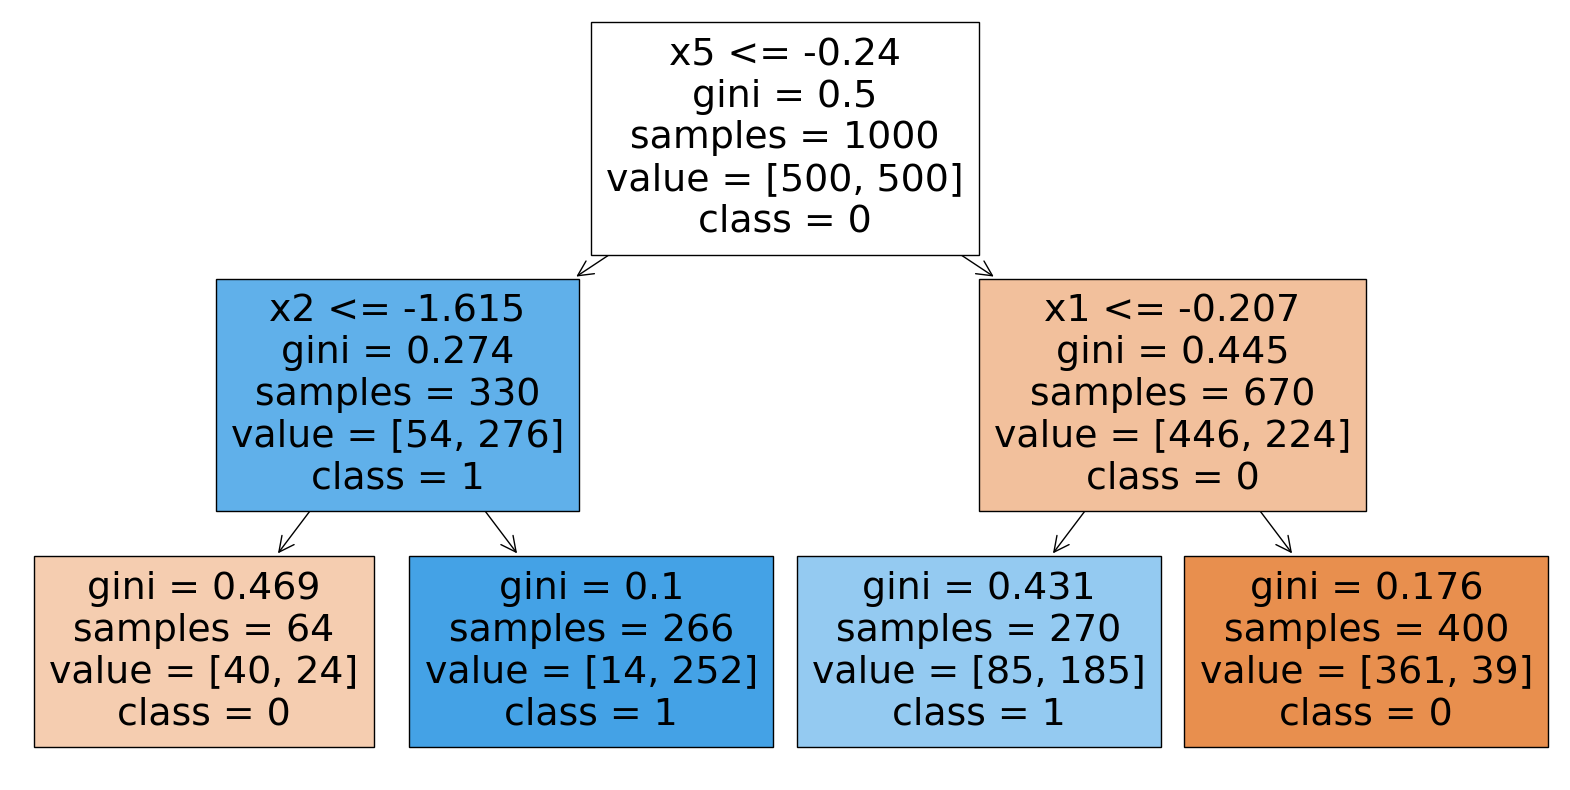

In [24]:
# Print representation of decision tree model using matplotlib
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=["x1", "x2", "x3", "x4", "x5"], class_names=["0", "1"], filled=True)

In [25]:
# Select points classified as 0
dt_0_class_points = X_simple_models_dataset[dt_model.predict(X_simple_models_dataset) == 0]

In [26]:
# Create NICE counterfactuals for 0 classified points
dt_nice_cf = NICE(
    predict_fn=dt_model.predict_proba, 
    X_train=X_simple_models_dataset, 
    y_train=y_simple_models_dataset, 
    cat_feat=[])
dt_cfs = [dt_nice_cf.explain(np.array([x])) for x in dt_0_class_points]

# Create CounterPlot Explanation Generator
dt_ctp_exp = counterplot_explainer(
    lambda x: dt_nice_cf.explain(np.array([x]))[0], 
    ['x1', 'x2', 'x3', 'x4', 'x5'], 
    {0: '0', 1: '1'},
    dt_model.predict_proba)

# Create CounterPlot explanations
dt_cpt_results, dt_cpt_results_idx, dt_cpt_gen_times = generate_explanations(
    dt_0_class_points, dt_ctp_exp.explain)

In [27]:
# Create SHAP explainer object
dt_shap = shap.KernelExplainer(dt_model.predict_proba, X_simple_models_dataset)

# Create SHAP explanation generator
dt_shap_exp = shap_explainer(dt_shap.shap_values)

# Create SHAP explanations
dt_shap_results, dt_shap_results_idx, dt_shap_gen_times = generate_explanations(
    dt_0_class_points, dt_shap_exp.explain)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [28]:
# Create LIME explainer object
dt_lime = lime.lime_tabular.LimeTabularExplainer(
    X_simple_models_dataset, 
    feature_names=["x1", "x2", "x3", "x4", "x5"], 
    class_names={0: "0", 1: "1"})

# Create LIME explanation generator
dt_lime_exp = lime_explainer(dt_lime, dt_model.predict_proba)

# Create LIME explanations
dt_lime_results, dt_lime_results_idx, dt_lime_gen_times = generate_explanations(
    dt_0_class_points, dt_lime_exp.explain)

In [29]:
# Get average importance values for each feature

dt_fi_avg_cpt = pd.DataFrame(dt_cpt_results_idx).mean().sort_index()
dt_fi_avg_shap = pd.DataFrame(dt_shap_results_idx).mean().sort_index()
dt_fi_avg_lime = pd.DataFrame(dt_lime_results_idx).mean().sort_index()

pd.DataFrame([dt_fi_avg_cpt, dt_fi_avg_shap, dt_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1,4,2,3
CounterPlot,0.584818,0.458510,0.774288,NaN,NaN
SHAP,-0.154768,-0.045887,-0.163570,0.000000,0.000000
LIME,-0.117219,-0.032294,-0.109508,-0.000916,-0.000337


In [30]:
# Get times which importance values were different from 0

iw_csv_dt = (pd.DataFrame(dt_cpt_results_idx).abs() >= 1e-10).mean().sort_index()
iw_shap_dt = (pd.DataFrame(dt_shap_results_idx).abs() >= 1e-10 ).mean().sort_index()
iw_lime_dt = (pd.DataFrame(dt_lime_results_idx).abs() >= 1e-10 ).mean().sort_index()

pd.DataFrame([iw_csv_dt, iw_shap_dt, iw_lime_dt], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1,4,2,3
CounterPlot,0.44181,0.200431,0.44181,NaN,NaN
SHAP,1.00000,1.000000,1.00000,0.0,0.0
LIME,1.00000,1.000000,1.00000,1.0,1.0


In [31]:
pd.DataFrame(dt_shap_results_idx)[2][0] >= 1e-10 

False

In [32]:
for method_name, fi_data in zip(['cf', 'shap', 'lime'], [dt_cpt_results_idx, dt_shap_results_idx, dt_lime_results_idx]):
    for feat_idx in range(5):
        create_hist_fi(feat_idx, fi_data, ["1st", "2nd", "3rd", "4th", "5th"], [-0.5, 1], [0, 350], f'./plots/simple_models/dt_{method_name}_{feat_idx}.pdf')

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

In [33]:
dt_data_avg = pd.DataFrame([dt_fi_avg_cpt, dt_fi_avg_shap, dt_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])
# Order columns
dt_data_avg = dt_data_avg[[0, 1, 2, 3, 4]]
# Round to 2 decimal places
dt_data_avg = dt_data_avg.round(4)
# Print latex, with ordered columns
print(dt_data_avg.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &       0 &       1 &       2 &       3 &       4 \\
\midrule
CounterPlot &  0.5848 &  0.4585 &     NaN &     NaN &  0.7743 \\
SHAP        & -0.1548 & -0.0459 &  0.0000 &  0.0000 & -0.1636 \\
LIME        & -0.1172 & -0.0323 & -0.0009 & -0.0003 & -0.1095 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [34]:
# Get overall statistics for each explanation method
pd.DataFrame(dt_cpt_results_idx).describe()

,4,0,1
count,205.000000,205.000000,93.000000
mean,0.774288,0.584818,0.458510
std,0.156500,0.028952,0.140833
min,0.016343,0.293843,0.286184
25%,0.849868,0.587685,0.286184
50%,0.849868,0.587685,0.572368
75%,0.849868,0.587685,0.572368
max,0.849868,0.587685,0.572368


In [35]:
# Get overall statistics for each explanation method
pd.DataFrame(dt_shap_results_idx).describe()

,0,1,2,3,4
count,464.000000,464.000000,464.0,464.0,464.000000
mean,-0.154768,-0.045887,0.0,0.0,-0.163570
std,0.073036,0.108978,0.0,0.0,0.144344
min,-0.180126,-0.301066,0.0,0.0,-0.240690
25%,-0.180126,-0.076125,0.0,0.0,-0.240690
50%,-0.180126,0.018316,0.0,0.0,-0.240690
75%,-0.180126,0.018316,0.0,0.0,-0.146249
max,0.117537,0.018316,0.0,0.0,0.255403


In [36]:
# Get overall statistics for each explanation method
pd.DataFrame(dt_lime_results_idx).describe()

,0,1,2,3,4
count,464.000000,464.000000,464.000000,464.000000,464.000000
mean,-0.117219,-0.032294,-0.000916,-0.000337,-0.109508
std,0.123576,0.107003,0.010769,0.010299,0.191963
min,-0.221894,-0.198099,-0.039169,-0.035992,-0.242242
25%,-0.187967,-0.159232,-0.007464,-0.006963,-0.218606
50%,-0.178773,0.042357,-0.000786,-0.000592,-0.205549
75%,-0.009965,0.054807,0.006683,0.006036,-0.056901
max,0.374944,0.082588,0.029518,0.030890,0.478248


#### KNN Classifier
Here a KNN classifier is used with an artificially generated dataset.
The dataset has 1000 samples with 2 informative features and 2 classes.

In [37]:
# Create dataset for KNN model
knn_models_dataset = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2, 
    n_redundant=0,
    n_repeated=0, 
    n_classes=2,
    random_state=42)

X_knn_models_dataset, y_knn_models_dataset = knn_models_dataset

<AxesSubplot: >

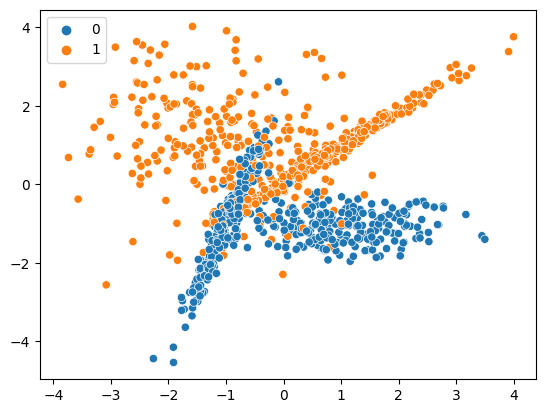

In [38]:
# Plot data points and classes
sns.scatterplot(x=X_knn_models_dataset[:,0], y=X_knn_models_dataset[:,1], hue=y_knn_models_dataset)

In [39]:
# Import scikit-learn KNN package
from sklearn.neighbors import KNeighborsClassifier

In [40]:
# Create KNN model with default parameters
knn_model = KNeighborsClassifier()

In [41]:
# Train KNN model
knn_model.fit(X_knn_models_dataset, y_knn_models_dataset)

KNeighborsClassifier()

In [42]:
# Print the accuracy of the KNN model
print("Accuracy of KNN model: ", knn_model.score(X_knn_models_dataset, y_knn_models_dataset))

Accuracy of KNN model:  0.938


In [43]:
# Select points classified as 0
knn_0_class_points = X_knn_models_dataset[knn_model.predict(X_knn_models_dataset) == 0]

In [44]:
# Create NICE counterfactuals for 0 classified points
knn_nice_cf = NICE(
    predict_fn=knn_model.predict_proba, 
    X_train=X_knn_models_dataset, 
    y_train=y_knn_models_dataset, 
    cat_feat=[])
knn_cfs = [knn_nice_cf.explain(np.array([x])) for x in knn_0_class_points]

# Create CounterPlot Explanation Generator
knn_ctp_exp = counterplot_explainer(
    lambda x: knn_nice_cf.explain(np.array([x]))[0], 
    ['x1', 'x2'], 
    {0: '0', 1: '1'},
    knn_model.predict_proba)

# Create CounterPlot explanations
knn_cpt_results, knn_cpt_results_idx, knn_cpt_gen_times = generate_explanations(
    knn_0_class_points, knn_ctp_exp.explain)

In [45]:
# Create SHAP explainer object
knn_shap = shap.KernelExplainer(knn_model.predict_proba, X_knn_models_dataset)

# Create SHAP explanation generator
knn_shap_exp = shap_explainer(knn_shap.shap_values)

# Create SHAP explanations
knn_shap_results, knn_shap_results_idx, knn_shap_gen_times = generate_explanations(
    knn_0_class_points, knn_shap_exp.explain)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [46]:
# Create LIME explainer object
knn_lime = lime.lime_tabular.LimeTabularExplainer(
    X_knn_models_dataset, 
    feature_names=["x1", "x2"], 
    class_names={0: "0", 1: "1"})

# Create LIME explanation generator
knn_lime_exp = lime_explainer(knn_lime, knn_model.predict_proba)

# Create LIME explanations
knn_lime_results, knn_lime_results_idx, knn_lime_gen_times = generate_explanations(
    knn_0_class_points, knn_lime_exp.explain)

In [47]:
# Get average importance values for each feature

knn_fi_avg_cpt = pd.DataFrame(knn_cpt_results_idx).mean().sort_index()
knn_fi_avg_shap = pd.DataFrame(knn_shap_results_idx).mean().sort_index()
knn_fi_avg_lime = pd.DataFrame(knn_lime_results_idx).mean().sort_index()

pd.DataFrame([knn_fi_avg_cpt, knn_fi_avg_shap, knn_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1
CounterPlot,0.349387,0.497005
SHAP,-0.084062,-0.333610
LIME,-0.014941,-0.349528


In [48]:
# Get times which importance values were different from 0

iw_csv_knn = (pd.DataFrame(knn_cpt_results_idx).abs() >= 1e-10 ).mean().sort_index()
iw_shap_knn = (pd.DataFrame(knn_shap_results_idx).abs() >= 1e-10 ).mean().sort_index()
iw_lime_knn = (pd.DataFrame(knn_lime_results_idx).abs() >= 1e-10 ).mean().sort_index()

pd.DataFrame([iw_csv_knn, iw_shap_knn, iw_lime_knn], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1
CounterPlot,0.622605,0.816092
SHAP,1.000000,1.000000
LIME,1.000000,1.000000


In [49]:
for method_name, fi_data in zip(['cf', 'shap', 'lime'], [knn_cpt_results_idx, knn_shap_results_idx, knn_lime_results_idx]):
    for feat_idx in range(2):
        create_hist_fi(feat_idx, fi_data, ["1st", "2nd"], [-1, 1], [0, 250], f'./plots/simple_models/knn_{method_name}_{feat_idx}.pdf')

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

In [50]:
knn_data_avg = pd.DataFrame([knn_fi_avg_cpt, knn_fi_avg_shap, knn_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME']).T
# Round values to 2 decimal places
knn_data_avg = knn_data_avg.round(2)
# Print latex table
print(knn_data_avg.T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &     0 &     1 \\
\midrule
CounterPlot &  0.35 &  0.50 \\
SHAP        & -0.08 & -0.33 \\
LIME        & -0.01 & -0.35 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [51]:
# Get overall statistics for each explanation method
pd.DataFrame(knn_cpt_results_idx).describe()

,0,1
count,3.260000e+02,4.340000e+02
mean,3.493865e-01,4.970046e-01
std,1.765906e-01,2.326973e-01
min,-2.775558e-17,-2.775558e-17
25%,2.000000e-01,4.000000e-01
50%,3.000000e-01,5.000000e-01
75%,4.000000e-01,6.000000e-01
max,8.000000e-01,1.000000e+00


In [52]:
# Get overall statistics for each explanation method
pd.DataFrame(knn_shap_results_idx).describe()

,0,1
count,522.000000,522.000000
mean,-0.084062,-0.333610
std,0.122548,0.163451
min,-0.465500,-0.686700
25%,-0.147150,-0.431675
50%,-0.077950,-0.359550
75%,-0.001850,-0.276525
max,0.324800,0.174200


In [53]:
# Get overall statistics for each explanation method
pd.DataFrame(knn_lime_results_idx).describe()

,0,1
count,522.000000,522.000000
mean,-0.014941,-0.349528
std,0.195973,0.243717
min,-0.229846,-0.563979
25%,-0.165320,-0.534357
50%,-0.095281,-0.336473
75%,-0.017748,-0.293293
max,0.373353,0.570572
